In [1]:
import pennylane as qml
import pennylane.numpy as np
import numpy as illegal_but_typed_np
from numpy.typing import NDArray

## 1. Set up circuit to optimize

In [2]:
from circuits import sim_02, sim_03

num_layers = 5
num_qubits = 4

# works as expected!
# circuit = sim_03(num_layers, num_qubits)
# initial_params = (
#     np.array(np.random.random((num_layers, num_qubits, 2))),
#     np.array(np.random.random((num_layers, num_qubits - 1)))
# )

circuit = sim_02(num_layers, num_qubits)
initial_params = (
    np.array(np.random.random((num_layers, num_qubits, 2))),
    np.array([])
)

print(qml.draw(circuit)(*initial_params))

# demo circuit from Rotosolve docs, crotosolve cannot solve this
# dev = qml.device('default.qubit', wires=3, shots=None)
# @qml.qnode(dev)
# def circuit(rot_param: NDArray, layer_param: float, crot_param: NDArray):
#     for i, par in enumerate(rot_param):
#         qml.RX(par, wires=i)
#     for w in dev.wires:
#         qml.RX(layer_param, wires=w)
#     for i, par in enumerate(crot_param):
#         qml.CRY(par, wires=[i, (i+1) % 3])
#     return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2))
# params = (
#     np.array([0.3, 0.2, 0.67], requires_grad=True),
#     np.array(1.1, requires_grad=True),
#     np.array([-0.2, 0.1, -2.5], requires_grad=True)
# )

0: ──RX(0.75)──RY(0.33)───────╭X──||──RX(0.34)──RY(0.69)───────╭X──||──RX(0.21)──RY(0.47)───────╭X
1: ──RX(0.16)──RY(0.45)────╭X─╰●──||──RX(0.19)──RY(0.70)────╭X─╰●──||──RX(0.26)──RY(0.49)────╭X─╰●
2: ──RX(0.40)──RY(0.82)─╭X─╰●─────||──RX(0.70)──RY(0.67)─╭X─╰●─────||──RX(0.50)──RY(0.17)─╭X─╰●───
3: ──RX(0.56)──RY(0.60)─╰●────────||──RX(0.94)──RY(0.82)─╰●────────||──RX(0.91)──RY(0.49)─╰●──────

───||──RX(0.73)──RY(0.56)───────╭X──||──RX(0.80)──RY(0.93)───────╭X──||─┤  <Z>
───||──RX(0.44)──RY(0.68)────╭X─╰●──||──RX(0.10)──RY(0.70)────╭X─╰●──||─┤     
───||──RX(0.02)──RY(0.16)─╭X─╰●─────||──RX(0.70)──RY(0.46)─╭X─╰●─────||─┤     
───||──RX(0.14)──RY(0.72)─╰●────────||──RX(0.39)──RY(0.63)─╰●────────||─┤     


## 2. Run `Crotosolve` optimization

In [3]:
from CrotosolveOptimizer import CrotosolveOptimizer

# optimizer = qml.AdamOptimizer()

max_iterations = 5#100
convergence_threshold = 1e-06

optimizer = CrotosolveOptimizer()

#iterations_dataset = [circuit(params)] # store initial cost
cost = [(0, float(circuit(*initial_params)))]
params = initial_params
for iteration in range(max_iterations):
    #with qml.Tracker(circuit.device) as tracker:
    params, prev_cost, sub_cost = optimizer.step_and_cost(
        circuit,
        *params,
        full_output=True
    )

    sub_cost_rp = sub_cost[:params[0].size]
    sub_cost_crp = sub_cost[params[0].size:]

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.extend([
        (
            evaluations_so_far + 1 + 2 * (cost_idx + 1),
            float(cost_value)
        )
        for (cost_idx, cost_value)
        in enumerate(sub_cost_rp)
    ])

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.extend([
        (
            evaluations_so_far + 5 * (cost_idx + 1),
            float(cost_value)
        )
        for (cost_idx, cost_value)
        in enumerate(sub_cost_crp)
    ])

    if np.abs(circuit(*params) - prev_cost) <= convergence_threshold:
        print("abort", iteration)
        break

crotosolve_cost = cost

## 3. Run `Rotosolve` optimization

In [4]:
max_iterations = 5#100
convergence_threshold = 1e-06

optimizer = qml.RotosolveOptimizer()
params = initial_params

spectrum_fn = qml.fourier.qnode_spectrum(circuit)
spectra = spectrum_fn(*params)
#iterations_dataset = [circuit(params)] # store initial cost
cost = [(0, float(circuit(*initial_params)))]
for iteration in range(max_iterations):
    #with qml.Tracker(circuit.device) as tracker: -> 2 per param shift rule appl.
    params, prev_cost, sub_cost = optimizer.step_and_cost(
        circuit,
        *params,
        spectra=spectra,
        full_output=True
    )

    sub_cost_rp = sub_cost[:params[0].size]
    sub_cost_crp = sub_cost[params[0].size:]

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.extend([
        (
            evaluations_so_far + 2 * (cost_idx + 1) + 1,
            float(cost_value)
        )
        for (cost_idx, cost_value)
        in enumerate(sub_cost_rp)
    ])

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.extend([
        (
            evaluations_so_far + 6 * (cost_idx + 1),
            float(cost_value)
        )
        for (cost_idx, cost_value)
        in enumerate(sub_cost_crp)
    ])

    if np.abs(circuit(*params) - prev_cost) <= convergence_threshold:
        print("abort", iteration)
        break

rotosolve_cost = cost

/home/max/Projects/bachelor-thesis/.venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


## 4. Run `GradientDescent` optimization

In [5]:
max_iterations = 500
convergence_threshold = 1e-06

optimizer = qml.GradientDescentOptimizer()
params = initial_params

#iterations_dataset = [circuit(params)] # store initial cost
cost = [(0, float(circuit(*initial_params)))]
for iteration in range(max_iterations):
    #with qml.Tracker(circuit.device) as tracker: # TODO: this does not work as expected, should return  >=2 executions per param shift rule appl.
    params, prev_cost = optimizer.step_and_cost(
        circuit,
        *params,
    )
    evaluations_here = 2
    current_cost = float(circuit(*params))

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.append((evaluations_so_far + evaluations_here, current_cost))

    if np.abs(circuit(*params) - prev_cost) <= convergence_threshold:
        print("abort", iteration)
        break

gradientdescent_cost = cost

## 5. Run `Adam` optimization

In [6]:
max_iterations = 500
convergence_threshold = 1e-06

optimizer = qml.AdamOptimizer()
params = initial_params

#iterations_dataset = [circuit(params)] # store initial cost
cost = [(0, float(circuit(*initial_params)))]
for iteration in range(max_iterations):
    #with qml.Tracker(circuit.device) as tracker: # TODO: this does not work as expected, should return  >=2 executions per param shift rule appl.
    params, prev_cost = optimizer.step_and_cost(
        circuit,
        *params,
    )
    evaluations_here = 2
    current_cost = float(circuit(*params))

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.append((evaluations_so_far + evaluations_here, current_cost))

    if np.abs(circuit(*params) - prev_cost) <= convergence_threshold:
        print("abort", iteration)
        break

adam_cost = cost

abort 109


## 5. Run `Adagrad` optimization

In [7]:
max_iterations = 500
convergence_threshold = 1e-06

optimizer = qml.AdagradOptimizer()
params = initial_params

#iterations_dataset = [circuit(params)] # store initial cost
cost = [(0, float(circuit(*initial_params)))]
for iteration in range(max_iterations):
    #with qml.Tracker(circuit.device) as tracker: # TODO: this does not work as expected, should return  >=2 executions per param shift rule appl.
    params, prev_cost = optimizer.step_and_cost(
        circuit,
        *params,
    )
    evaluations_here = 2
    current_cost = float(circuit(*params))

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.append((evaluations_so_far + evaluations_here, current_cost))

    if np.abs(circuit(*params) - prev_cost) <= convergence_threshold:
        print("abort", iteration)
        break

adagrad_cost = cost

## N. Plot loss curve

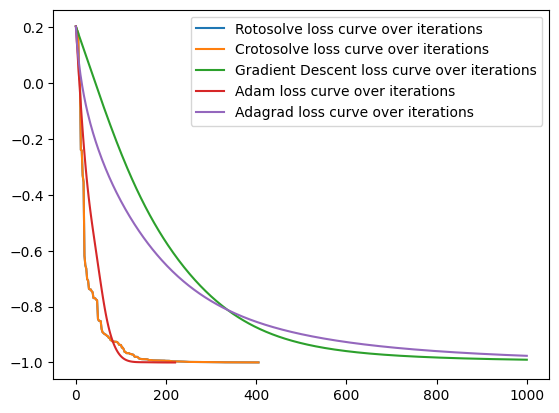

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# ax.plot(range(len(iterations_dataset)), iterations_dataset, 'b')
# ax.set_title("Loss curve over iterations")

plot_data = [
    ("Rotosolve", rotosolve_cost),
    ("Crotosolve", crotosolve_cost),
    ("Gradient Descent", gradientdescent_cost),
    ("Adam", adam_cost),
    ("Adagrad", adagrad_cost)
]

for optimizer_name, loss_curve_data in plot_data:
    x, y = zip(*loss_curve_data) # this unzips the list of points

    ax.plot(x, y, label=f"{optimizer_name} loss curve over iterations")
    ax.legend()